## 含并行联结的网络：GoogLeNet

- 2014年的ImageNet图像识别挑战赛中大放异彩；
- 重点是解决了什么样大小的卷积核最合适的问题；
- 本文的一个观点是，有时使用不同大小的卷积核组合是有利的。

下面介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，但是现在有了更好的训练算法，这些特性不是必要的。

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import sys
sys.path.append('..')
import utils
import d2l

### 1、Inception块

4个路径，从不同层面抽取信息，然后在输出通道维上做合并：
- 各个通道使用不同窗口大小的卷积层；有用了MaxPool；
- 用1 $\times$ 1的卷积，来降低通道数，控制模型复杂度；每条路上的通道数可能不同；
- 四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。

<img src='https://d2l.ai/_images/inception.svg' style="zoom:100%;" />

<img src='./figs/3.jpg' style="zoom:20%;" />

在Inception块中，通常调整的超参数是*每层输出通道数*。

具体用什么数值？调出来的，指导思想：（待补充）

In [3]:
class Inception(nn.Module):
    '''
    Inception块的定义，输出通道数 = c1 + c2[1] + c3[1] + c4

    Parameters:
    - in_channels: 输入通道数
    - c1: int，线路1（1x1卷积）的输出通道数
    - c2: tuple，线路2（1x1卷积接3x3卷积）两层各自的输出通道数
    - c3: tuple，线路3（1x1卷积接3x3卷积）两层各自的输出通道数
    - c4: int，线路4（$3\times 3$最大池化接$1\tiems 1$卷积）的输出通道数
    '''
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)       # 四维：（batch、channel、height、width）

### 2、GoogLeNet

- 5段，9个Incption块（不改变高宽只改变通道数）
- 最后放一个Global AveragePooling，得到一个长为输入通道数的向量，再放入全连接层；

<img src='./figs/4.jpg' style="zoom:30%;" />

下面逐一实现各段：

### 2.1、段1&2

<img src='./figs/5.jpg' style="zoom:30%;" />

更小的窗口

In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

### 2.2、段3

<img src='./figs/6.jpg' style="zoom:30%;" />

估计是做了超参数搜索，长得特别奇怪。

In [5]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

### 2.3、段4&5

<img src='./figs/7.jpg' style="zoom:30%;" />

In [6]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),                                 # 微调，不用计算卷积核的大小，方便
                   nn.Flatten())

### 2.4、实现

In [16]:
class GoogLeNet(nn.Module):
    '''
    GoogLeNet原版实现

    Parameters:
    - in_channels: 输入的通道数
    - classes: 类别数
    '''
    def __init__(self,in_channels,classes):
        super(GoogLeNet,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels,out_channels=64,kernel_size=7,stride=2,padding=3),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=1),nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=192,kernel_size=3,padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),
            Inception(192,c1=64,c2=[96,128],c3=[16,32],c4=32),
            Inception(256,c1=128,c2=[128,192],c3=[32,96],c4=64),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
            Inception(480,c1=192,c2=[96,208],c3=[16,48],c4=64),
            Inception(512,c1=160,c2=[112,224],c3=[24,64],c4=64),
            Inception(512,c1=128,c2=[128,256],c3=[24,64],c4=64),
            Inception(512,c1=112,c2=[144,288],c3=[32,64],c4=64),
            Inception(528,c1=256,c2=[160,320],c3=[32,128],c4=128),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
            Inception(832,c1=256,c2=[160,320],c3=[32,128],c4=128),
            Inception(832,c1=384,c2=[192,384],c3=[48,128],c4=128),
            nn.AvgPool2d(kernel_size=7,stride=1),                       # 由于只是针对ImageNet实现的，所以没有用nn.AdaptiveAvgPool2d((1,1))
            nn.Dropout(p=0.4),
            nn.Flatten(),
            nn.Linear(1024,classes),
            nn.Softmax(dim=1)
        )

    def forward(self,X:torch.tensor):
        return self.model(X)

    def test(self, X:torch.tensor):
        for layer in self.model:
            X = layer(X)
            print(layer.__class__.__name__,'output shape:',X.shape)

### 3、训练

In [17]:
net = GoogLeNet(1, 10)
X = torch.rand(size=(1, 1, 224, 224))
net.test(X)

Conv2d output shape: torch.Size([1, 64, 112, 112])
ReLU output shape: torch.Size([1, 64, 112, 112])
MaxPool2d output shape: torch.Size([1, 64, 55, 55])
Conv2d output shape: torch.Size([1, 64, 55, 55])
ReLU output shape: torch.Size([1, 64, 55, 55])
Conv2d output shape: torch.Size([1, 192, 55, 55])
ReLU output shape: torch.Size([1, 192, 55, 55])
MaxPool2d output shape: torch.Size([1, 192, 27, 27])
Inception output shape: torch.Size([1, 256, 27, 27])
Inception output shape: torch.Size([1, 480, 27, 27])
MaxPool2d output shape: torch.Size([1, 480, 14, 14])
Inception output shape: torch.Size([1, 512, 14, 14])
Inception output shape: torch.Size([1, 512, 14, 14])
Inception output shape: torch.Size([1, 512, 14, 14])
Inception output shape: torch.Size([1, 528, 14, 14])
Inception output shape: torch.Size([1, 832, 14, 14])
MaxPool2d output shape: torch.Size([1, 832, 7, 7])
Inception output shape: torch.Size([1, 832, 7, 7])
Inception output shape: torch.Size([1, 1024, 7, 7])
AvgPool2d output shape:

loss 1.798, train acc 0.663, test acc 0.657
1072.1 examples/sec on cuda:1


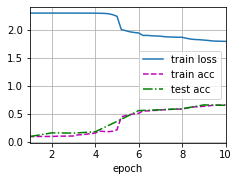

In [18]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, '../data', resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu(1))

直接使用原版的GoogLeNet，在Fashion-MNIST上效果不好；

GoogLeNet模型的计算复杂，而且不如VGG那样便于修改通道数。为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96，这简化了计算。

loss 0.270, train acc 0.897, test acc 0.884
3161.2 examples/sec on cuda:1


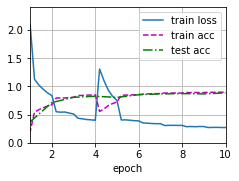

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, '../data', resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu(1))

为什么会有这样的波动曲线？？？

### 4、后续变种

Inception块后续变种：
- Inception-BN(V2)：使用 batch normalization；
- Inception-V3：修改了Inception块：（小核多卷几次，比大核好，虽然更贵）
  - 段3，替换$5\times 5$为多个$3\times 3$卷积层；
  - 段4，替换$3\times 3$为$1\times 7$和$7\times 1$卷积层；替换$5\times 5$为两个$1\times 7$和$7\times 1$卷积层；
  - 段5，替换$3\times 3$为并行的$1\times 3$和$3\times 1$卷积层；替换$5\times 5$为$3\times 3$后接并行的$1\times 3$和$3\times 1$卷积层；
  - 更深。
- Inception-V4：使用残差连接。

### 5、小结

- Inception块使用4条有不同超参数的卷积层和池化层的路径，来抽取不同的信息；
  - 模型参数小（指相对同层数网络而言），计算复杂度低；
  - 但内部设计复杂，不方便调参，难复现；
- GoogLeNet使用9个Inception块，是第一个达到上百层（不是上百深度）的网络；后续有一系列改进，适应时代。